# Imports

In [29]:
import pandas as pd
from pandas import Series,DataFrame
from pandas_datareader import DataReader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

sns.set_style('whitegrid')

### Objetivos

* Qual foi a mudança no preço da ação ao longo do tempo
* Qual foi o retorno diário das ações em média
* Qual foi o ***movimentação*** média de várias ações
* Qual foi a correlação de diferentes ações no período de fechamento
* Qual foi a correlação entre diferentes ações e seus retornos diários
* Quanto risco está envolvido em investir em uma Ação em particular
* Como podemos prever o comportamento das ações

### Lista com as  companhias que quero utilizar como exemplo

In [126]:
stock_market_list = ['TWTR','AMD','INTC','NVDA']

### Agora, estabeleço o ***range*** temporal que quero para analisar

In [18]:
end_day = datetime.today() # Final
start_day = datetime(end_day.year-1,end_day.month,end_day.day) # Inicio = Final - 1

In [148]:
twitter = DataReader(stock_market_list[0],'yahoo',start_day,end_day)
amd = DataReader(stock_market_list[1],'yahoo',start_day,end_day)
ge = DataReader(stock_market_list[2],'yahoo',start_day,end_day)
nvidia = DataReader(stock_market_list[3],'yahoo',start_day,end_day)

# Plot para o Preço Ajustado da ação

**Para mais info**: 


[1] https://www.investopedia.com/terms/a/adjusted_closing_price.asp


[2] https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

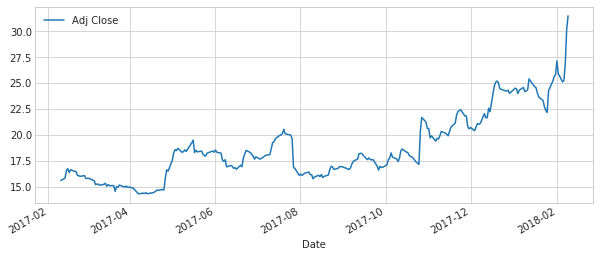

In [31]:
twitter['Adj Close'].plot(legend=True,figsize=(10,4))

# Plot para o volume das vendas

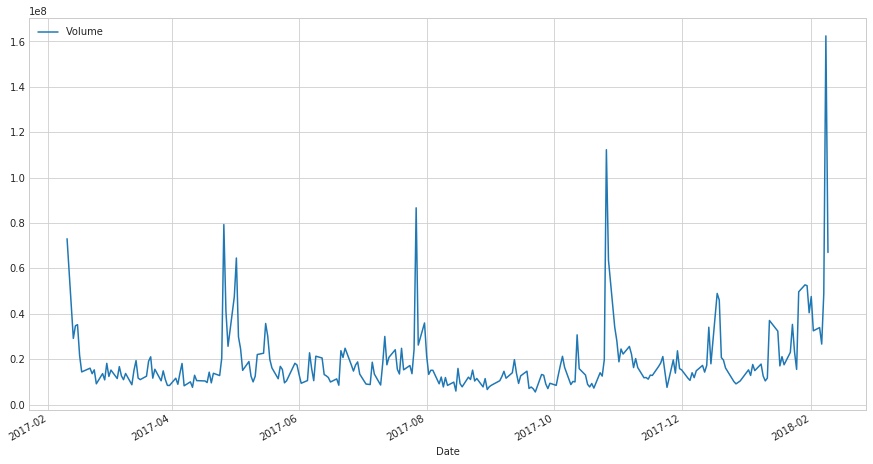

In [41]:
twitter['Volume'].plot(legend=True,figsize=(15,8))

# Moving Average

[1] https://www.investopedia.com/terms/m/movingaverage.asp


[2] https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

In [85]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for {} day".format(ma)
    twitter[column_name] = twitter.rolling(on='Adj Close',window=ma).mean()

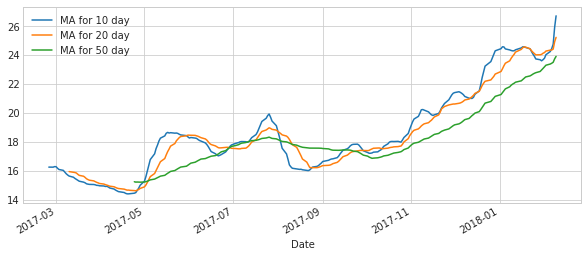

In [86]:
twitter[['MA for 10 day','MA for 20 day','MA for 50 day']].plot(subplots=False,legend=True,figsize=(10,4))

# Analise do Retorno diário

[1] **pct_change**: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pct_change.html


[2] **sns.distplot**: https://seaborn.pydata.org/generated/seaborn.distplot.html

In [90]:
twitter['Daily Return'] = twitter['Adj Close'].pct_change()

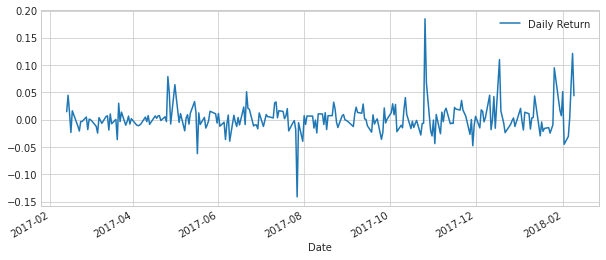

In [94]:
twitter['Daily Return'].plot(legend=True,figsize=(10,4))

# Plot da distribuição do retorno diário

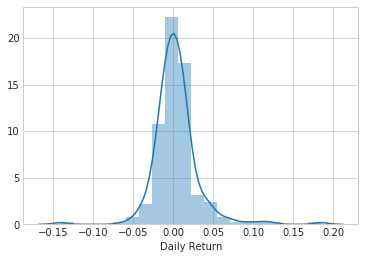

In [120]:
sns.distplot(twitter['Daily Return'].dropna(),bins=20)

# Análise do retorno diário de todas as  empresas. 

In [127]:
cl = DataReader(stock_market_list,'yahoo',start_day,end_day)['Adj Close']

In [128]:
cl.head()

,AMD,INTC,NVDA,TWTR
Date,,,,
2018-02-09,11.31,43.950001,232.080002,31.510000
2018-02-08,11.22,42.750000,217.520004,30.180000
2018-02-07,11.60,45.200001,228.800003,26.910000
2018-02-06,11.65,44.910000,225.580002,25.240000
2018-02-05,11.57,44.220001,213.699997,25.129999


In [129]:
tech_return = cl.pct_change().dropna()
tech_return.head()

,AMD,INTC,NVDA,TWTR
Date,,,,
2018-02-08,-0.007958,-0.027304,-0.062737,-0.042209
2018-02-07,0.033868,0.057310,0.051857,-0.108350
2018-02-06,0.004310,-0.006416,-0.014073,-0.062059
2018-02-05,-0.006867,-0.015364,-0.052664,-0.004358
2018-02-02,0.076059,0.036613,0.092747,0.031437


## Correlação entre o preço das açõesde 2 empresas

[1] jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html

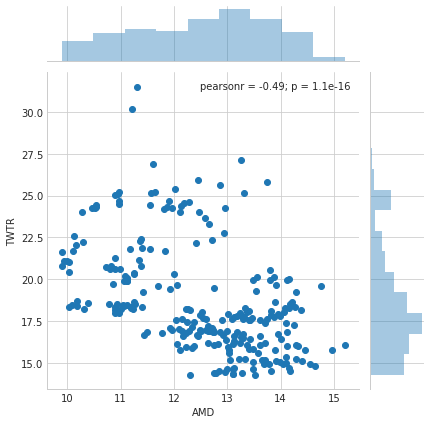

In [130]:
sns.jointplot('AMD','TWTR',cl,kind='scatter')

## PairPlot, uma maneira de plotar todas as combinações das correlações

[1] pairplot: https://seaborn.pydata.org/generated/seaborn.pairplot.html

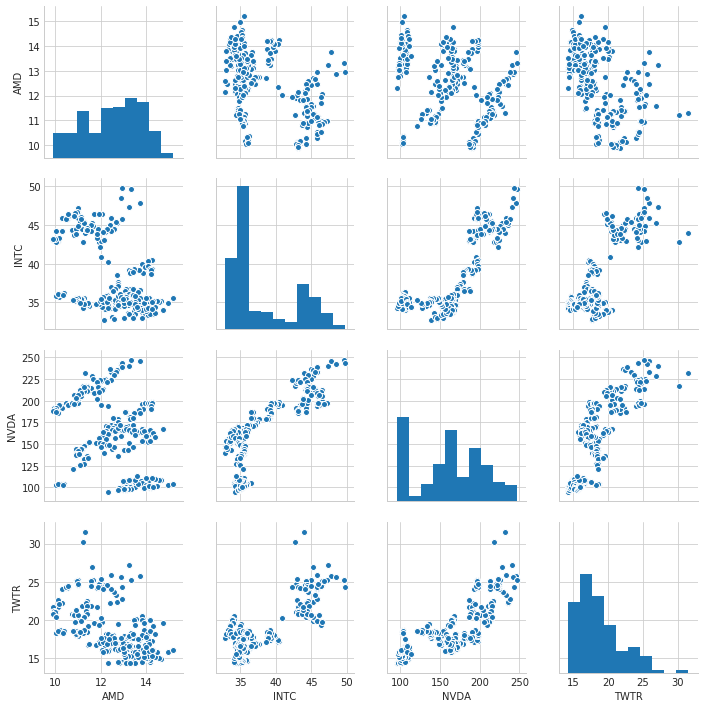

In [131]:
sns.pairplot(cl.dropna())

In [136]:
closing_prices_df = DataReader(stock_market_list,'yahoo',start_day,end_day)['Close']

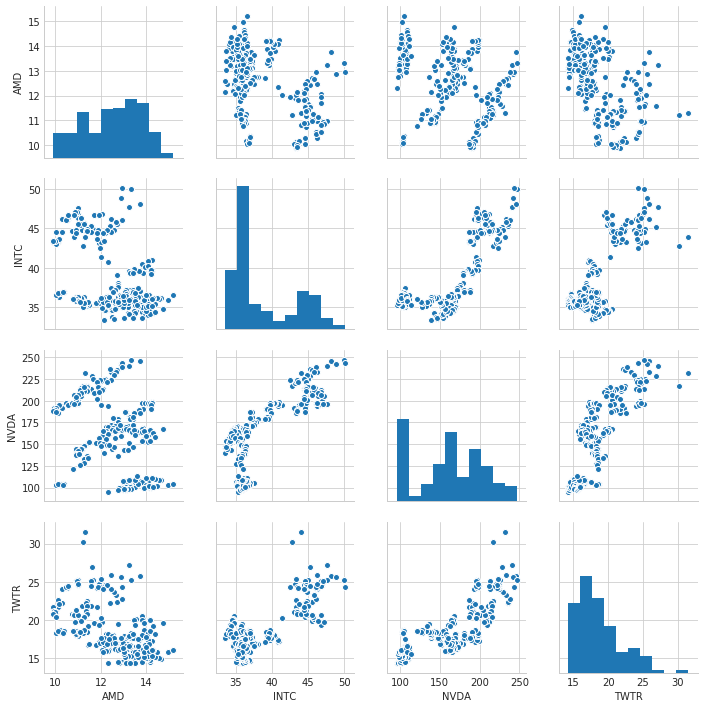

In [138]:
sns.pairplot(closing_prices_df)

# Agora, vamos encontrar os riscos dessas ações


[1] **matplotlib.annotate**: https://matplotlib.org/users/annotations_intro.html

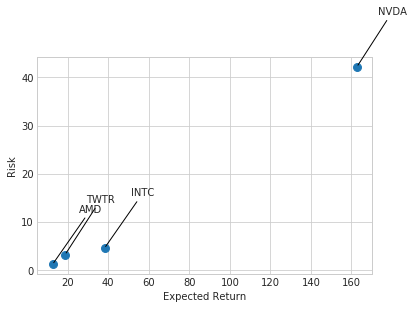

In [147]:
area = np.pi*20

plt.scatter(cl.mean(),cl.std(),s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')

for label,x,y in zip(cl.columns,cl.mean(),cl.std()):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(50,50),
        textcoords = 'offset points',
        ha='right',
        va='bottom',
        arrowprops= dict(arrowstyle='-',connectionstyle='arc3')
    )

## Outra maneira de avaliar o risco de uma ação

[1] - **Quantile**: https://en.wikipedia.org/wiki/Quantile


[2] - **Quantile 2** : https://www.stat.auckland.ac.nz/~ihaka/787/lectures-quantiles-handouts.pdf

[3] - **Pandas.Quantile**: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.quantile.html

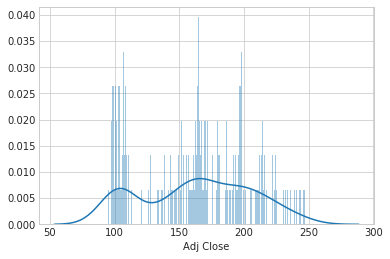

In [151]:
sns.distplot(nvidia['Adj Close'],bins=252)

In [152]:
nvidia['Adj Close'].quantile(0.05)

99.24342535

### Método de Monte Carlo

[1] **Investopedia** - https://www.investopedia.com/terms/m/montecarlosimulation.asp

In [156]:
days = 365
dt = 1/days
mu = cl.mean()['TWTR']
sigma = cl.std()['TWTR']

In [175]:
def monte_carlo_stock(start_price,days,dt,mu,sigma):
    
    price = np.zeros(days)
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    price[0] = start_price
    
    for x in range(1,days):
        shock[x] = np.random.normal(loc=mu*dt,scale= sigma*np.sqrt(dt))
        drift[x] = mu*dt
        price[x] = price[x-1] + (price[x-1]*(drift[x]+shock[x]))
        
    return price

In [176]:
twitter.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-10,15.960000,16.000000,15.500000,15.58,15.58,73061200
2017-02-13,15.630000,15.990000,15.510000,15.81,15.81,29143700
2017-02-14,15.920000,16.600000,15.850000,16.52,16.52,34709300
2017-02-15,16.850000,16.889999,16.299999,16.74,16.74,35204800
2017-02-16,16.690001,16.790001,16.320000,16.35,16.35,21636200


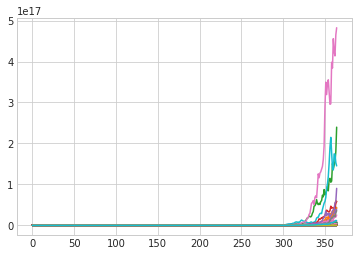

In [177]:
start_price = 15.96

for run in range(100):
    plt.plot(monte_carlo_stock(start_price,days,dt,mu,sigma))